# Import Libraries

In [1]:
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

db_url = 'sqlite:///../store_sales.db'
engine = create_engine(db_url, pool_pre_ping= True)

SessionLocal = sessionmaker(
    autocommit = False,
    autoflush= False,
    bind = engine
)

# Data Reading

In [2]:
with SessionLocal() as session:
    q = text('SELECT * FROM sales')
    df_sales = pd.DataFrame(session.execute(q))
    q = text('SELECT * FROM oil')
    df_oil = pd.DataFrame(session.execute(q))
    q = text('SELECT * FROM holidays')
    df_holidays = pd.DataFrame(session.execute(q))
    q = text('SELECT * FROM stores')
    df_stores = pd.DataFrame(session.execute(q))
    q = text('SELECT * FROM transactions')
    df_transactions = pd.DataFrame(session.execute(q))

# Basic Data Overview

In [3]:
df_sales.head()

,ID,DATE,STORE_NBR,FAMILY,SALES,ONPROMOTION
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
stores_count = df_sales['STORE_NBR'].nunique()
products_count = df_sales['FAMILY'].nunique()
ts_count = stores_count * products_count
print(f'Number of time series = {ts_count}')

Number of time series = 1782


In [5]:
df_oil.head()

,DATE,DCOILWTICO
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [6]:
df_holidays.head()

,DATE,TYPE,LOCALE,LOCALE_NAME,DESCRIPTION,TRANSFERRED
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,0
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,0
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,0
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,0
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,0


In [7]:
df_stores.head()

,STORE_NBR,CITY,STATE,TYPE,CLUSTER
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [8]:
df_transactions.head()

,DATE,STORE_NBR,TRANSACTIONS
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [9]:
# Print basic information about each dataframe
for df in [df_sales, df_stores, df_holidays, df_oil, df_transactions]:
    print(df.info())
    print('\n')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ID           object 
 1   DATE         object 
 2   STORE_NBR    int64  
 3   FAMILY       object 
 4   SALES        float64
 5   ONPROMOTION  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 137.4+ MB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   STORE_NBR  54 non-null     int64 
 1   CITY       54 non-null     object
 2   STATE      54 non-null     object
 3   TYPE       54 non-null     object
 4   CLUSTER    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------

# Descriptive Statistics

In [10]:
# Descriptive statistics for numerical columns
print(df_sales.describe())
print(df_oil.describe())
print(df_transactions.describe())

          STORE_NBR         SALES   ONPROMOTION
count  3.000888e+06  3.000888e+06  3.000888e+06
mean   2.750000e+01  3.577757e+02  2.602770e+00
std    1.558579e+01  1.101998e+03  1.221888e+01
min    1.000000e+00  0.000000e+00  0.000000e+00
25%    1.400000e+01  0.000000e+00  0.000000e+00
50%    2.750000e+01  1.100000e+01  0.000000e+00
75%    4.100000e+01  1.958473e+02  0.000000e+00
max    5.400000e+01  1.247170e+05  7.410000e+02
        DCOILWTICO
count  1175.000000
mean     67.714366
std      25.630476
min      26.190000
25%      46.405000
50%      53.190000
75%      95.660000
max     110.620000
          STORE_NBR  TRANSACTIONS
count  83488.000000  83488.000000
mean      26.939237   1694.602158
std       15.608204    963.286644
min        1.000000      5.000000
25%       13.000000   1046.000000
50%       27.000000   1393.000000
75%       40.000000   2079.000000
max       54.000000   8359.000000


# Distribution of Target Variable

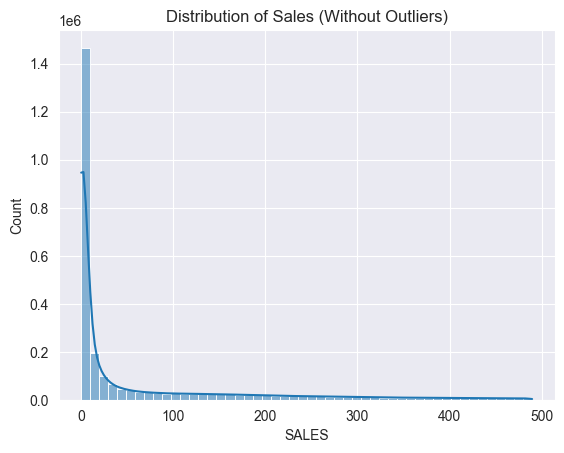

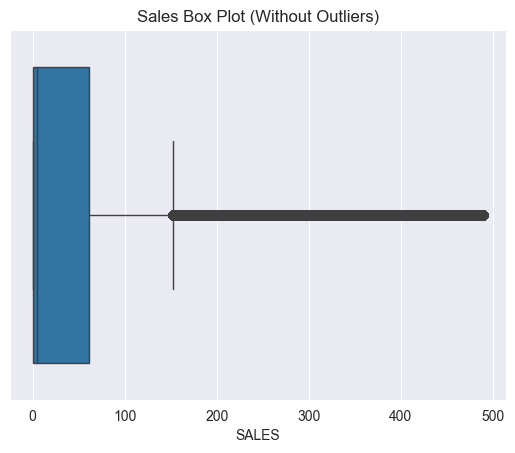

In [11]:
# Calculate the first and third quartile
Q1 = df_sales['SALES'].quantile(0.25)
Q3 = df_sales['SALES'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_sales_filtered = df_sales[(df_sales['SALES'] >= lower_bound) & (df_sales['SALES'] <= upper_bound)]

# Plot the distribution of sales without outliers
sns.histplot(df_sales_filtered['SALES'], bins=50, kde=True)
plt.title('Distribution of Sales (Without Outliers)')
plt.show()

# Additionally, you can use a box plot to visually confirm the reduction of outliers
sns.boxplot(x=df_sales_filtered['SALES'])
plt.title('Sales Box Plot (Without Outliers)')
plt.show()


# Time Series Analysis of Sales and Oil Price

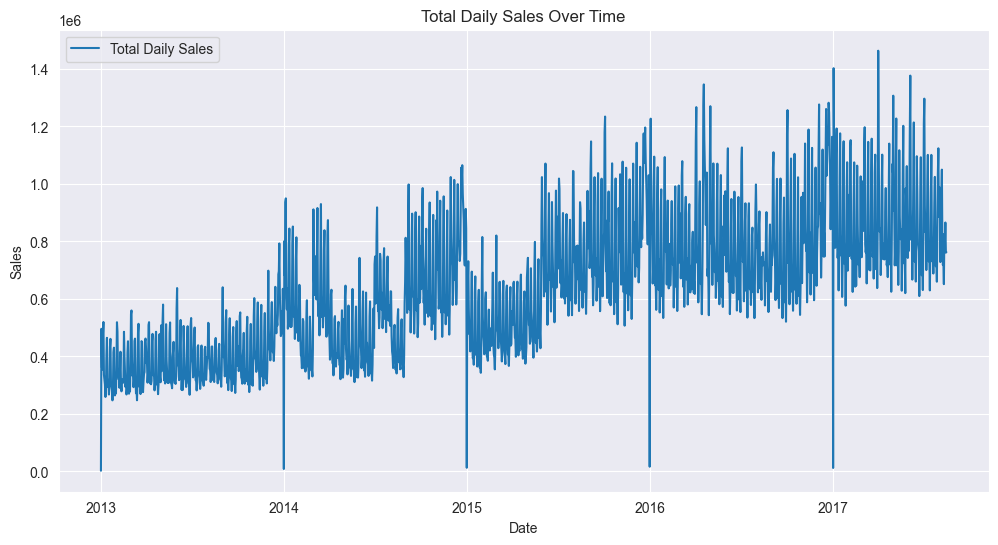

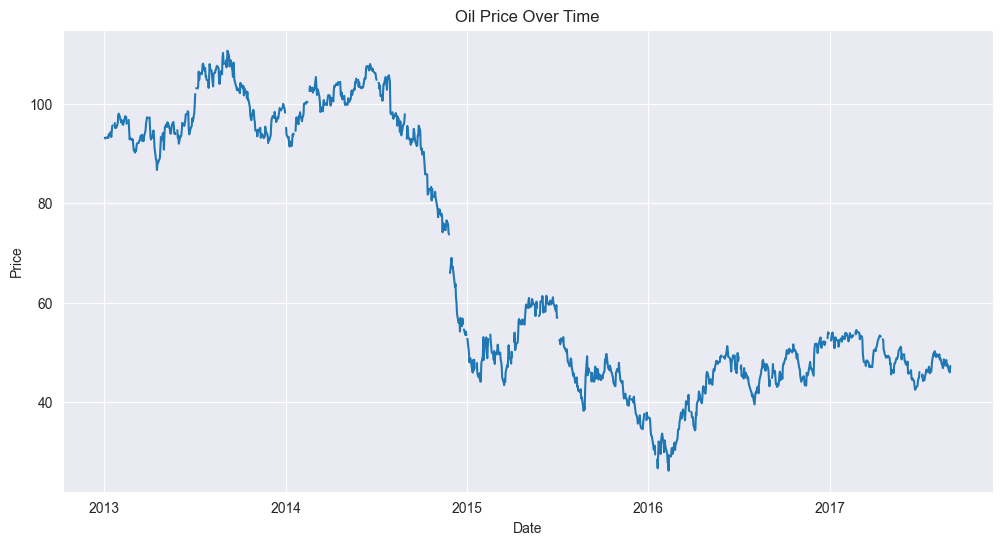

In [12]:
# Aggregate sales by date
df_sales['DATE'] = pd.to_datetime(df_sales['DATE'])
daily_sales = df_sales.groupby('DATE')['SALES'].sum().reset_index()

# Time series plot of aggregated daily sales
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['DATE'], daily_sales['SALES'], label='Total Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Total Daily Sales Over Time')
plt.legend()
plt.show()

# Time series plot of oil prices
df_oil['DATE'] = pd.to_datetime(df_oil['DATE'])
df_oil_sorted = df_oil.sort_values('DATE')
plt.figure(figsize=(12, 6))
plt.plot(df_oil_sorted['DATE'], df_oil_sorted['DCOILWTICO'])
plt.title('Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


# Correlation Analysis

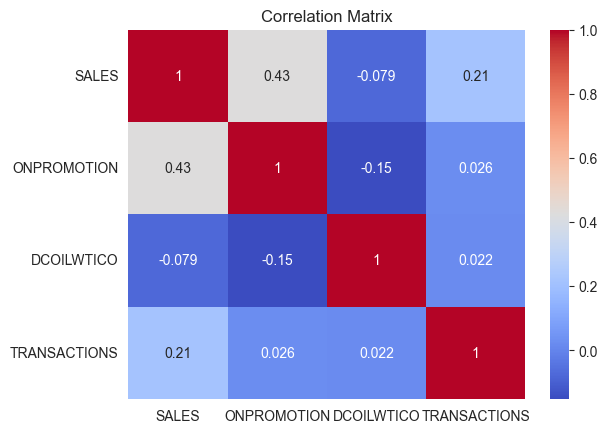

In [13]:
# Merge datasets for correlation analysis
df_transactions['DATE'] = pd.to_datetime(df_transactions['DATE'])
df_merged = pd.merge(df_sales, df_oil, on='DATE', how='left')
df_merged = pd.merge(df_merged, df_transactions, on=['DATE', 'STORE_NBR'], how='left')

# Correlation matrix
corr_matrix = df_merged[['SALES', 'ONPROMOTION', 'DCOILWTICO', 'TRANSACTIONS']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

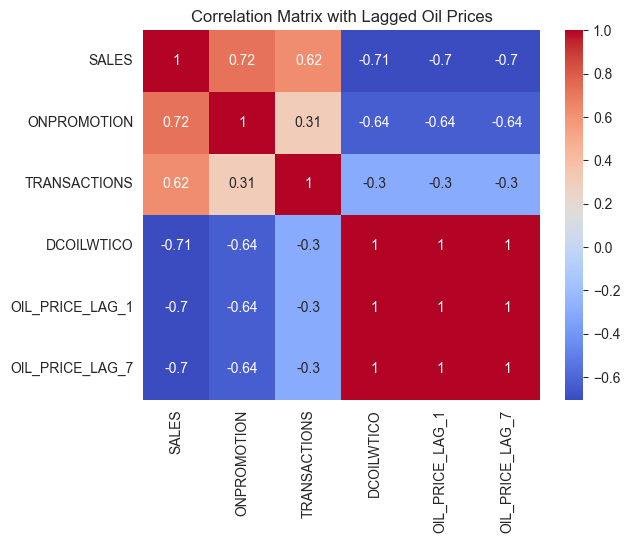

In [14]:
# Ensure DATE columns in both df_sales and df_oil are in datetime format for merging
df_sales['DATE'] = pd.to_datetime(df_sales['DATE'])
df_oil['DATE'] = pd.to_datetime(df_oil['DATE'])

# Merge the sales data with the oil prices on the same date
df_merged = pd.merge(df_sales, df_oil, on='DATE', how='left')

# Adding lagged oil prices: 1 day before and 7 days before
df_merged['OIL_PRICE_LAG_1'] = df_merged['DCOILWTICO'].shift(1)
df_merged['OIL_PRICE_LAG_7'] = df_merged['DCOILWTICO'].shift(7)

# Since we're interested in the overall daily sales, let's aggregate sales by date
daily_sales_merged = df_merged.groupby('DATE').agg({'SALES':'sum', 'ONPROMOTION':'sum', 'DCOILWTICO':'first', 'OIL_PRICE_LAG_1':'first', 'OIL_PRICE_LAG_7':'first'}).reset_index()

# Now, merge this with the daily transactions to get a comprehensive dataframe
daily_sales_merged = pd.merge(daily_sales_merged, df_transactions.groupby('DATE')['TRANSACTIONS'].sum().reset_index(), on='DATE', how='left')

# Dropping initial rows with NaN values due to lagging
daily_sales_merged = daily_sales_merged.dropna()

# Correlation matrix including lagged oil prices
corr_matrix_with_lags = daily_sales_merged[['SALES', 'ONPROMOTION', 'TRANSACTIONS', 'DCOILWTICO', 'OIL_PRICE_LAG_1', 'OIL_PRICE_LAG_7']].corr()

# Visualizing the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(corr_matrix_with_lags, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix with Lagged Oil Prices')
plt.show()


# Impact of Holidays on Sales

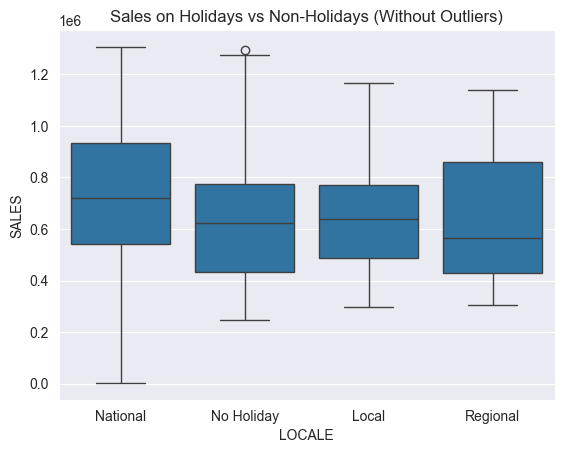

In [18]:
# Merge holidays information
df_holidays['DATE'] = pd.to_datetime(df_holidays['DATE'])
df_sales_holidays = pd.merge(df_sales, df_holidays[['DATE', 'LOCALE', 'TRANSFERRED']], on='DATE', how='left')
df_sales_holidays['IS_HOLIDAY'] = ~df_sales_holidays['LOCALE'].isnull()
df_sales_holidays.fillna({'LOCALE':'No Holiday'}, inplace=True)

# Aggregate sales by date
daily_sales_holidays = df_sales_holidays.groupby(['DATE', 'IS_HOLIDAY', 'LOCALE'])['SALES'].sum().reset_index()

# Calculate IQR for sales to remove outliers
Q1 = daily_sales_holidays['SALES'].quantile(0.25)
Q3 = daily_sales_holidays['SALES'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
filtered_daily_sales_holidays = daily_sales_holidays[(daily_sales_holidays['SALES'] >= lower_bound) & (daily_sales_holidays['SALES'] <= upper_bound)]

# Box plot to compare sales on holidays vs non-holidays (without outliers)
sns.boxplot(x='LOCALE', y='SALES', data=filtered_daily_sales_holidays)
plt.title('Sales on Holidays vs Non-Holidays (Without Outliers)')
plt.show()


# Store Characteristics

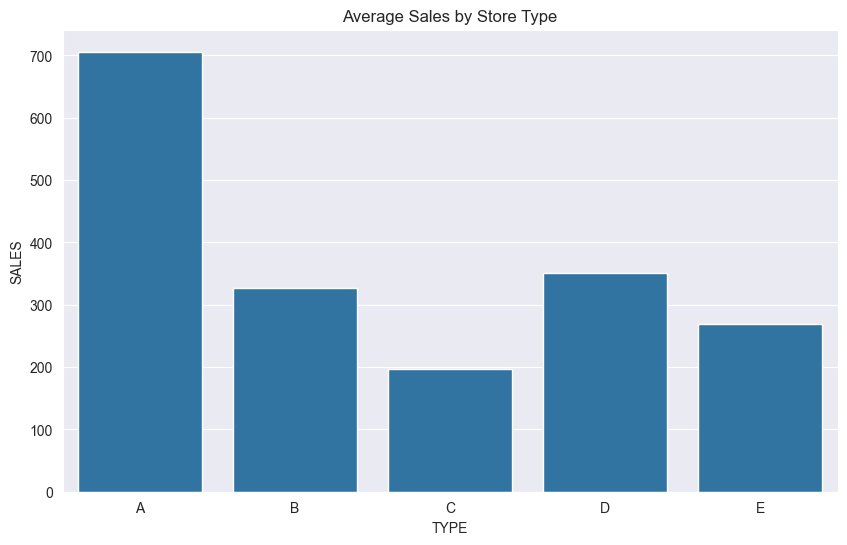

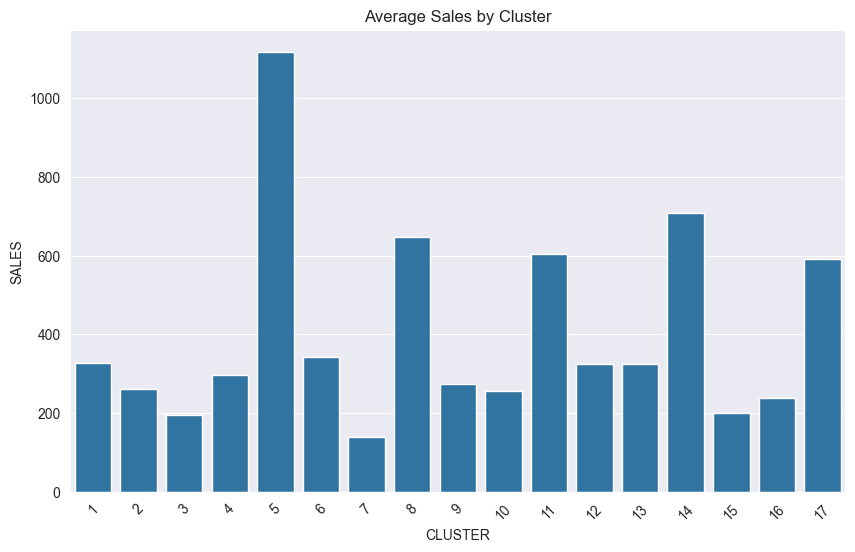

In [16]:
# Merge sales data with store information
df_sales_stores = pd.merge(df_sales, df_stores, on='STORE_NBR', how='left')

# Aggregate sales by store type, averaging over all product families
sales_by_store_type = df_sales_stores.groupby('TYPE')['SALES'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='TYPE', y='SALES', data=sales_by_store_type)
plt.title('Average Sales by Store Type')
plt.show()

# Aggregate sales by cluster, averaging over all product families
sales_by_cluster = df_sales_stores.groupby('CLUSTER')['SALES'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='CLUSTER', y='SALES', data=sales_by_cluster)
plt.title('Average Sales by Cluster')
plt.xticks(rotation=45)
plt.show()

# ACF and PACF

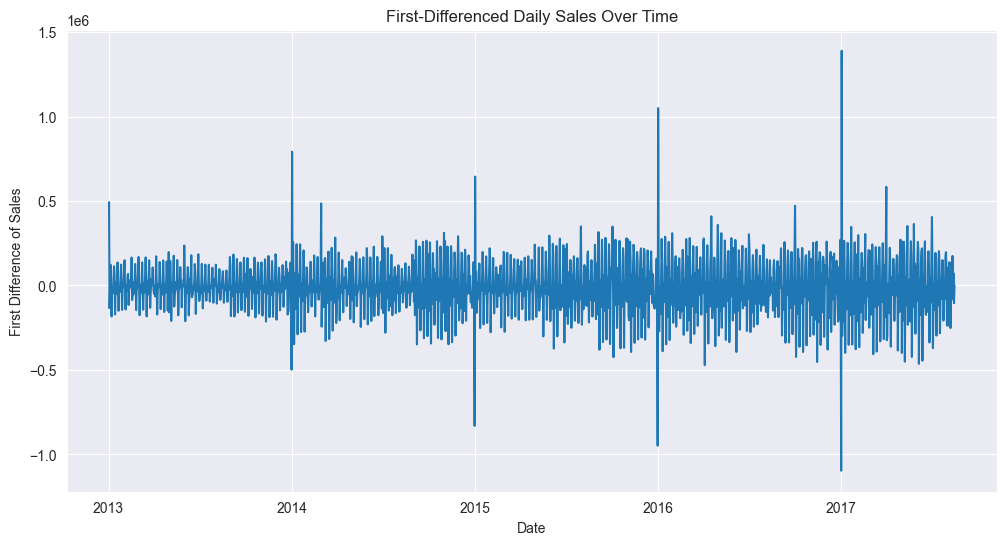

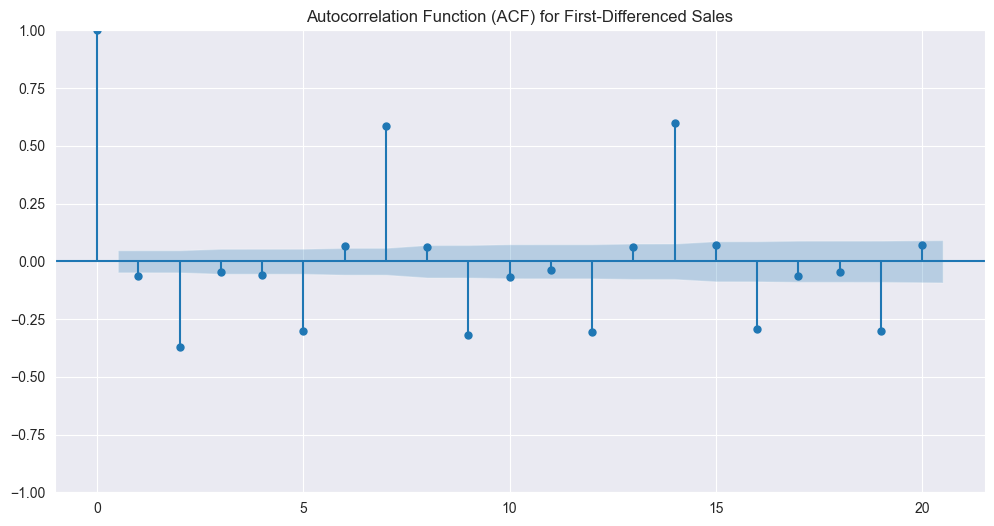

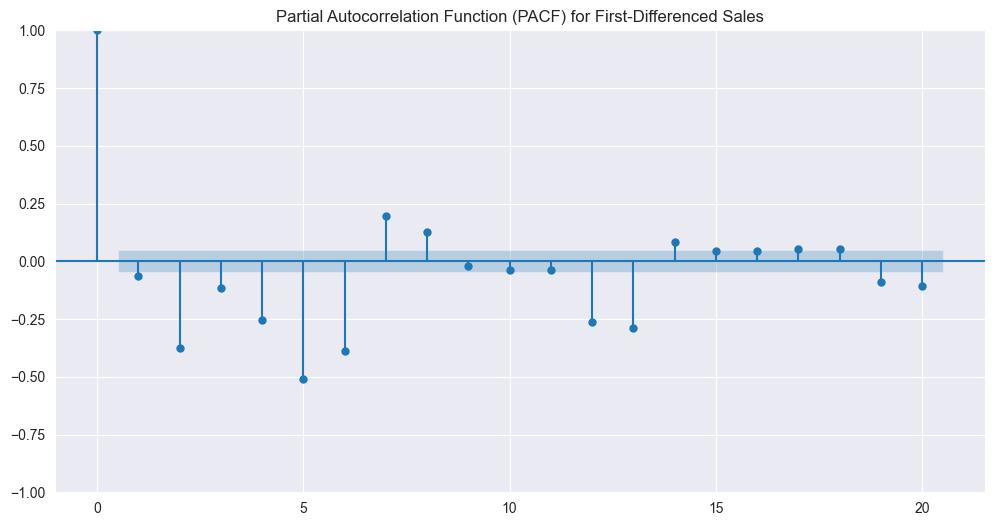

In [17]:
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Aggregate sales by date to get the total daily sales
daily_sales = df_sales.groupby('DATE')['SALES'].sum().reset_index()

# First, ensure 'DATE' is the DataFrame index for easier differencing
daily_sales.set_index('DATE', inplace=True)

# Apply first difference to the daily sales series
daily_sales['SALES_DIFF'] = daily_sales['SALES'].diff()

# Drop the first row as it will be NaN after differencing
daily_sales_diff = daily_sales.dropna()

# Plotting the first-differenced sales series
plt.figure(figsize=(12, 6))
plt.plot(daily_sales_diff.index, daily_sales_diff['SALES_DIFF'])
plt.title('First-Differenced Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('First Difference of Sales')
plt.show()


plt.figure(figsize=(12, 6))
plot_acf(daily_sales_diff['SALES_DIFF'], lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) for First-Differenced Sales')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(daily_sales_diff['SALES_DIFF'], lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) for First-Differenced Sales')
plt.show()
